# Models

In [38]:
import copy
from dataloader import DataLoader
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as lng
import scipy.io as io
from sklearn.ensemble import BaggingClassifier, AdaBoostRegressor
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from pathlib import Path
import pandas as pd
import seaborn as sns

## Data

In [2]:
d = DataLoader()

In [45]:
data_loader = copy.deepcopy(d)

cols_to_standardize = ["SeatCapacity", "LoadFactor"]
cols_to_onehot = ['Destination', 'Sector',
       'AircraftType', 'FlightType', 'FlightNumber',
       # 'Hour', 'Weekday', 'Month', 'Year'
       ]
cols_to_use = ["ScheduleTime"] + cols_to_standardize + cols_to_onehot + ['Holiday'] + ["TimeCos", "TimeSin", "DayCos", "DaySin", "MonthCos", "MonthSin"]

# retrive cols to use
data_loader.special_transforms()
data_loader = data_loader.get_subset(*cols_to_use)

# make one hot encoding
data_loader = data_loader.onehot_encode(*cols_to_onehot)

# get train-test split
train, test = data_loader.get_split()
train.data = train.data.loc[:, ~data_loader.data.columns.isin(["ScheduleTime"]) ]
test.data = test.data.loc[:, ~data_loader.data.columns.isin(["ScheduleTime"]) ]

# standardize
test = test.standardize(train.data, *cols_to_standardize)
train = train.standardize(None, *cols_to_standardize)


# train and test to X and y
X_train = train.data.loc[:, ~train.data.columns.isin(["LoadFactor"])]
X_val = test.data.loc[:, ~test.data.columns.isin(["LoadFactor"])]

y_train = train.data["LoadFactor"]
y_val = test.data["LoadFactor"]

In [7]:
get_passengers = lambda x: x * train.standardize_params[1] + train.standardize_params[0]

In [41]:
X_train

,SeatCapacity,Holiday,TimeCos,TimeSin,DayCos,DaySin,MonthCos,MonthSin,Destination_AFW,Destination_AHT,...,FlightNumber_ZY2290,FlightNumber_ZY2291,FlightNumber_ZY3307,FlightNumber_ZY811,FlightNumber_ZY813,FlightNumber_ZY814,FlightNumber_ZY816,FlightNumber_ZY817,FlightNumber_ZY821,FlightNumber_ZY823
0,0.574738,True,-0.021815,0.999762,1.0,0.000000e+00,1.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.222588,True,-0.152123,0.988362,1.0,0.000000e+00,1.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.523845,True,-0.573576,0.819152,1.0,0.000000e+00,1.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-1.376168,True,-0.932008,0.362438,1.0,0.000000e+00,1.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.222588,True,-0.999762,-0.021815,1.0,0.000000e+00,1.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35835,2.457787,False,0.642788,-0.766044,1.0,-2.449294e-16,1.0,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0
35836,-1.410096,False,0.737277,-0.675590,1.0,-2.449294e-16,1.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
35837,-1.104737,False,0.751840,-0.659346,1.0,-2.449294e-16,1.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
35838,0.574738,False,0.806445,-0.591310,1.0,-2.449294e-16,1.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Metrics


In [46]:
## Metrics

def relative_difference(y,y_hat):
    return (y-y_hat)/y
def accuracy(y,y_hat):
    return (1-np.abs(relative_difference(y,y_hat)))*100

def accuracy_score(y_true, y_pred):
    # y_true = get_passengers(y_true)
    # y_pred = get_passengers(y_pred)
    return accuracy(y_true,y_pred).mean()

score = make_scorer(accuracy_score, greater_is_better=True)

## Decision tree


Fitting 5 folds for each of 40 candidates, totalling 200 fits
best estimator: DecisionTreeRegressor(min_samples_leaf=191)


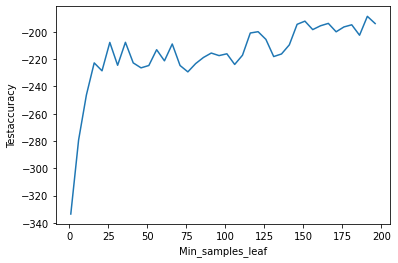

In [47]:
dtree=DecisionTreeRegressor()

candidates = range(1,200,5)

param_grid = {
    'min_samples_leaf': candidates,
    
}
cv_grid = GridSearchCV(estimator = dtree, param_grid = param_grid, cv = 5, verbose=2, n_jobs=-1,scoring=score)

# Fit the grid search model
cv_grid.fit(X_train, y_train)

#plot the results
plt.plot(candidates,cv_grid.cv_results_['mean_test_score'])
plt.xlabel('Min_samples_leaf')
plt.ylabel('Testaccuracy')
print(f'best estimator: {cv_grid.best_estimator_}')

In [ ]:
params = range(1,200,5)
accs = np.zeros((len(params)))
for i, param in enumerate(params):
    dtree = DecisionTreeRegressor(min_samples_leaf=param)
    dtree.fit(X_train, y_train)
    yhat = dtree.predict(X_train)
    accs[i] = accuracy_score(y_train, yhat)
    print(accs[i])


plt.plot(params, accs)

In [11]:
dtree = DecisionTreeRegressor(min_samples_leaf=71)
dtree.fit(X_train, y_train)
yhat = dtree.predict(X_train)
accuracy_score(y_train, yhat)

-59.68238266850075

In [18]:
# ((get_passengers(y_train)-get_passengers(yhat))/get_passengers(y_train)).mean()
accuracy_score(get_passengers(y_train), get_passengers(yhat)), accuracy_score(y_train, yhat)

(41.39671816892342, -59.68238266850075)

In [13]:
get_passengers(y_train)

0         5.0
1        58.0
2        26.0
3        14.0
4        81.0
         ... 
35835    59.0
35836    18.0
35837    10.0
35838    59.0
35840     6.0
Name: Passengers, Length: 35793, dtype: float64

In [23]:
accuracy(y_train, yhat)

0         26.145686
1         34.431023
2          6.155454
3         69.251573
4       -141.144874
            ...    
35835   -343.686355
35836     81.681099
35837     91.118456
35838    -97.202545
35840     93.343093
Name: Passengers, Length: 35793, dtype: float64

In [24]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

tscv = TimeSeriesSplit(n_splits=2)
for train, test in tscv.split(X_train):
    print(train, test)


model = xgb.XGBRegressor()
param_search = {'max_depth' : [3, 5]}

tscv = TimeSeriesSplit(n_splits=2)
gsearch = GridSearchCV(estimator=model, cv=tscv,
                        param_grid=param_search, scoring=score)
gsearch.fit(X_train, y_train)

[    0     1     2 ... 11928 11929 11930] [11931 11932 11933 ... 23859 23860 23861]
[    0     1     2 ... 23859 23860 23861] [23862 23863 23864 ... 35790 35791 35792]


c:\Users\lukas\Git\Studie\02582_Computational_Data_Analysis\CDA-case-env\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\lukas\Git\Studie\02582_Computational_Data_Analysis\CDA-case-env\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\lukas\Git\Studie\02582_Computational_Data_Analysis\CDA-case-env\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\lukas\Git\Studie\02582_Computational_Data_Analysis\CDA-case-env\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
             

In [30]:
yhat = gsearch.predict(X_train)
accuracy_score(get_passengers(y_train), get_passengers(yhat)), accuracy_score(y_train, yhat)

c:\Users\lukas\Git\Studie\02582_Computational_Data_Analysis\CDA-case-env\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


(47.94730716715059, 39.032935756407554)

## Adaboost


In [39]:
# Try to experiment with max_samples, max_features, number of modles, and other models
n_estimators = range(5,101)
max_depth = range(1,11)

#We do an outer loop over max_depth here ourselves because we cannot include in the CV paramgrid.
#Notice this is not a "proper" way to select the best max_depth but for the purpose of vizuallizing behaviour it should do
test_acc = np.zeros((len(n_estimators), len(max_depth)))
for i in max_depth:
    
    # Create and fit an AdaBoosted decision tree
    boost = AdaBoostRegressor(DecisionTreeRegressor(max_depth = i), learning_rate= 1)

    params = {
        "n_estimators" : n_estimators,
        # "learning_rate" : np.arange(0.5, 2, .1)
    }

    boost_grid = GridSearchCV(boost, params, n_jobs = -1, verbose = 2, scoring = score)

    # Fit the grid search model
    boost_grid.fit(X_train, y_train)

    test_acc[:,i-1] = boost_grid.cv_results_['mean_test_score']

Fitting 5 folds for each of 96 candidates, totalling 480 fits


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))

ax.plot(n_estimators, test_acc)
ax.set_xlabel('Maximum tree depth')
ax.set_ylabel('Mean test accuracy')
# ax.legend(['MaxDepth=1','MaxDepth=2','MaxDepth=3','MaxDepth=4','MaxDepth=5','MaxDepth=6','MaxDepth=7','MaxDepth=8','MaxDepth=9','MaxDepth=10'])
ax.legend(["Maxdepth="+ str(i) for i in max_depth])